In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  5 10:44:06 2020

@author: triet
"""
import os
import pandas as pd
import numpy as np
import wget
from datetime import date
from datetime import timedelta  
from datetime import datetime 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy import array
from numpy import hstack
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
#refresh data from github of university Johns Hopkins
"""
base_data_path = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data_files = ["time_series_covid19_confirmed_global.csv", "time_series_covid19_deaths_global.csv", "time_series_covid19_recovered_global.csv"]

for file in data_files:
    if os.path.exists(file):
        os.remove(file)
    wget.download(os.path.join(base_data_path, file))
"""

'\nbase_data_path = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"\ndata_files = ["time_series_covid19_confirmed_global.csv", "time_series_covid19_deaths_global.csv", "time_series_covid19_recovered_global.csv"]\n\nfor file in data_files:\n    if os.path.exists(file):\n        os.remove(file)\n    wget.download(os.path.join(base_data_path, file))\n'

In [2]:
#get data of US
data_confirmed = np.asarray(pd.read_csv("./data/time_series_covid19_confirmed_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)
data_deaths = np.asarray(pd.read_csv("./data/time_series_covid19_deaths_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)
data_recovered = np.asarray(pd.read_csv("./data/time_series_covid19_recovered_global.csv").to_numpy()[225,4:], dtype=np.uint32).reshape(-1,1)

In [5]:
date_format = "%m/%d/%Y"

date_start = datetime.strptime('1/22/2020', date_format)
date_end = datetime.strptime('5/5/2020', date_format)

start_quarantine = datetime.strptime('3/15/2020', date_format)
end_quarantine = datetime.strptime('4/30/2020', date_format)

date_today = datetime.strptime(datetime.today().strftime("%m/%d/%Y"), date_format)

#---------IMPORTANT----------

#If date_today = datetime.strptime(datetime.today().strftime("%m/%d/%Y"), date_format) generates error
#Replace date_today by the day before

#which means : if today is 4/25/2020
# ===> replace date_today = datetime.strptime(datetime.today().strftime("%m/%d/%Y"), date_format)
# by:          date_today = datetime.strptime('4/24/2020', date_format)

#Because the data may not be updated today, so the lasted data is yesterday

In [6]:
start_to_now = (date_end - date_start).days
start_to_quarantS = (start_quarantine - date_start).days
quarantS_to_quarantE = (end_quarantine - start_quarantine).days
start_to_today = (date_today - date_start).days

quarant_include_future = np.zeros(start_to_now + 1)
quarant_include_future[start_to_quarantS : start_to_quarantS + quarantS_to_quarantE + 1] = 1
quarant_now = quarant_include_future[:start_to_today + 1]


In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append((seq_x))
        y.append(seq_y)
    return array(X), array(y)

In [8]:
n_steps = 1
n_features = 2


sc_C = StandardScaler()

data_C_1 = quarant_now.reshape(-1,1)
data_C_2 = data_confirmed

data_C = sc_C.fit_transform(hstack((data_C_1[:-n_steps],data_C_2[:-n_steps],data_C_2[n_steps:])))
mean = sc_C.mean_
std = np.sqrt(sc_C.var_)


In [9]:
print(len(data_C_1))
print(len(data_C_2))

94
94


In [10]:
n_steps = 1
n_features = 2
X, y = split_sequences(data_C, n_steps)

In [11]:
print(X.shape)

(93, 1, 2)


In [12]:
#build model
def build_model(nb_node):  
    model = Sequential()
    model.add(LSTM(nb_node, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.summary()
    return model

In [13]:
nb_node = 50
model_C = build_model(nb_node)
#compile model
model_C.compile(optimizer='adam', loss='mse')

# fit model
model_C.fit(X, y, epochs=200, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
def predict_include_future(model, data, nb_days, n_steps):
    k = len(data)
    y_preds = model.predict(data)
    for i in range(nb_days):
        data_1 = quarant_include_future[k + 1 + i - n_steps: k + 1 + i ].reshape(-1,1)
        data_2 = y_preds[-n_steps:]
        seq = hstack((data_1,data_2)).reshape(1,n_steps,n_features)
        pred_day = model.predict(seq)
        y_preds = np.concatenate((y_preds, pred_day))
    return y_preds

In [15]:
days_future = (date_end - date_today).days
y_pred_C_transformed = predict_include_future(model_C, X, days_future, n_steps)

In [16]:
days_future

11

In [17]:
y_pred_C = y_pred_C_transformed*std[2]+mean[2]

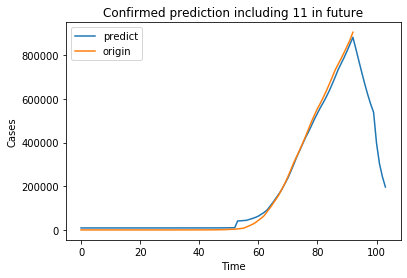

In [19]:
plt.plot(y_pred_C.reshape(-1,1), label='predict')
plt.plot(data_confirmed[n_steps:], label='origin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('Confirmed prediction including '+str(days_future)+' in future')
plt.show()